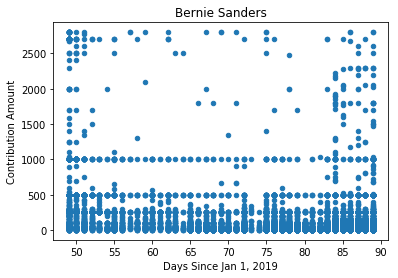

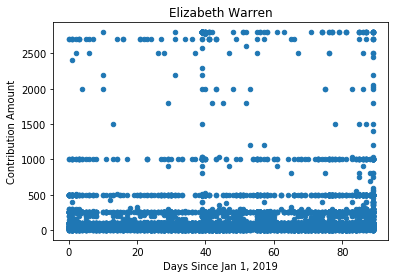

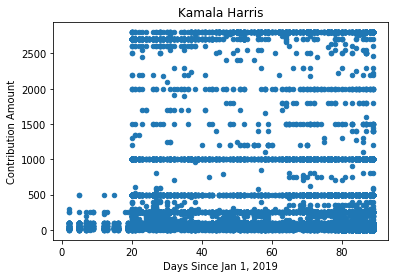

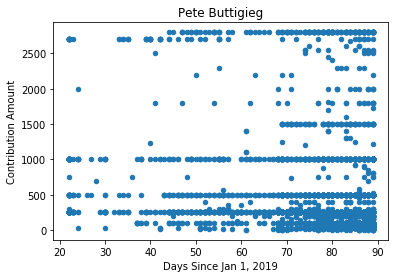

In [27]:
import pandas as pd
import geopandas as gpd
import descartes
import time
import datetime
import matplotlib.pyplot as plt
import geoplot

# If there is no exploratory committee 
# We "Start" the candidacy on 2019-01-01
candidates = {
    "bernie":
    {
        "real_name": "Bernie Sanders",
        "committee_id": "C00696948",
        "exploratory_start_date": "2019-01-01",
        "candidacy_start_date": "2019-02-19",
        "fec_data_file": "data/BernieQ12019.csv"
    },
    "elizabeth":
    {

        "real_name": "Elizabeth Warren",
        "committee_id": "C00693234",
        "exploratory_start_date": "2018-12-31",
        "candidacy_start_date": "2019-02-19",
        "fec_data_file": "data/WarrenForPresident2019.csv"
        
    },
    "kamala":
    {
        "real_name": "Kamala Harris",
        "committee_id": "C00694455",
        "exploratory_start_date": "2019-01-01",
        "candidacy_start_date": "2019-01-21",
        "fec_data_file": "data/KamalaHarris2019Q1.csv"
    },
    "pete": 
    {
        "real_name": "Pete Buttigieg",
        "committee_id": "C00697441",
        "exploratory_start_date": "2019-01-23",
        "candidacy_start_date": "2019-04-14",
        "fec_data_file": "data/buttigieg-q1-2019-donor.csv"
    },
}

# Cleaning and Loading
# Load a map file for visualization -- we actually use existing tools for this.
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2018&layergroup=ZIP+Code+Tabulation+Areas
# map_file = "data/tl_2018_us_zcta510.shp"
# map_df = gpd.read_file(map_file)
# map_df = map_df.rename(index=str, columns={'ZCTA5CE10': 'ZIP5'})

for candidate in candidates.keys():
    # Load a data file from the FEC about contributions
    # https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00697441&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020
    df = pd.read_csv(candidates[candidate]['fec_data_file'], parse_dates=['contribution_receipt_date'])
    exploratory_committee_start_date= '2019-01-01' # candidates[candidate]['exploratory_start_date']
    df['days_since_start'] = (df.contribution_receipt_date - pd.to_datetime(exploratory_committee_start_date)).dt.days

    # Let's clean the data a little by having a ZIP5 column that can join across sets
    df['ZIP5'] = df['contributor_zip'].apply(lambda x: str(x)[:5])

    # Let's just see what we have:
    # df.plot.scatter('days_since_start','contribution_receipt_amount')
    '''
    There is perhaps a story in the outliers.
    But let's filter the data set down to exclude chargebacks/refunds;
    let's also get rid of donations above the FEC limit of $2,800
    '''
    filtered =  df[ (df['contribution_receipt_amount'] > 0) & (df['contribution_receipt_amount'] <= 2800)]
    ax = filtered.plot.scatter(
        'days_since_start',
        'contribution_receipt_amount',
        title=candidates[candidate]['real_name']
    )
    ax.set_xlabel("Days Since Jan 1, 2019")
    ax.set_ylabel("Contribution Amount")    

    

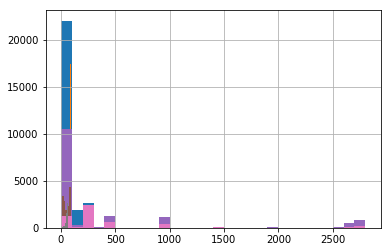

In [25]:
 for candidate in candidates.keys():
    # Load a data file from the FEC about contributions
    # https://www.fec.gov/data/receipts/individual-contributions/?two_year_transaction_period=2020&committee_id=C00697441&min_date=01%2F01%2F2019&max_date=12%2F31%2F2020
    df = pd.read_csv(candidates[candidate]['fec_data_file'], parse_dates=['contribution_receipt_date'])
    exploratory_committee_start_date= candidates[candidate]['exploratory_start_date']
    df['days_since_start'] = (df.contribution_receipt_date - pd.to_datetime(exploratory_committee_start_date)).dt.days

    # Let's clean the data a little by having a ZIP5 column that can join across sets
    df['ZIP5'] = df['contributor_zip'].apply(lambda x: str(x)[:5])

    # Let's just see what we have:
    # df.plot.scatter('days_since_start','contribution_receipt_amount')
    '''
    There is perhaps a story in the outliers.
    But let's filter the data set down to exclude chargebacks/refunds;
    let's also get rid of donations above the FEC limit of $2,800
    '''
    filtered =  df[ (df['contribution_receipt_amount'] > 0) & (df['contribution_receipt_amount'] <= 2800)]
    '''
    How are the donations distributed in time and amount?
    '''
    ax = filtered.contribution_receipt_amount.hist(bins=28)

    # ... and as we might expect the donations accelerate considerably over time.
    
    filtered.days_since_start.hist(bins=7)


In [29]:
'''
Ok, so a few questions now:
# Where do donors come from? (beast mode)
With thanks to https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
'''
for candidate in candidates.keys():
    donors_by_zip = filtered[['ZIP5', 'contribution_receipt_amount']]
    df = pd.read_csv(candidates[candidate]['fec_data_file'], parse_dates=['contribution_receipt_date'])
    exploratory_committee_start_date= candidates[candidate]['exploratory_start_date']
    df['days_since_start'] = (df.contribution_receipt_date - pd.to_datetime(exploratory_committee_start_date)).dt.days

    # Let's clean the data a little by having a ZIP5 column that can join across sets
    df['ZIP5'] = df['contributor_zip'].apply(lambda x: str(x)[:5])

    # Let's just see what we have:
    # df.plot.scatter('days_since_start','contribution_receipt_amount')
    '''
    There is perhaps a story in the outliers.
    But let's filter the data set down to exclude chargebacks/refunds;
    let's also get rid of donations above the FEC limit of $2,800
    '''
    filtered =  df[ (df['contribution_receipt_amount'] > 0) & (df['contribution_receipt_amount'] <= 2800)]
    agg = donors_by_zip.groupby(['ZIP5']).sum()
    # If we were doing native python plotting we'd do this
    # merged = pd.merge(map_df,agg, on='ZIP5')
    output_file = '/tmp/{}.csv'.format(candidate)
    agg.to_csv(output_file)
    print("Wrote to {}".format(output_file))
# Prettier interface is here:
# Buttigieg: http://www.openheatmap.com/view.html?map=DiscompaniedAngulousBlacklands
# Sanders: http://www.openheatmap.com/view.html?map=DitherersAllotriognathiClaimsman
# Warren: http://www.openheatmap.com/view.html?map=WolfersTakisJoensuu
# Harris: http://www.openheatmap.com/view.html?map=QuadrupletTestasAdrell


Wrote to /tmp/bernie.csv
Wrote to /tmp/elizabeth.csv
Wrote to /tmp/kamala.csv
Wrote to /tmp/pete.csv


In [ ]:
'''
Those pesky lobbyists, we can't have their money:
# https://soprweb.senate.gov/index.cfm?event=processLobbyistSearchCriteria
'''



In [ ]:
'''
What do donors do? (this is self reported, maybe not interesting.)
'''
'''
print(df.shape)
df = df.sort_values(by='contribution_receipt_amount')
len(df.contribution_receipt_amount.unique())
df_pretty = df[columns_filter]
df_pretty.head()
'''